# Machine Learning Project

### DESCRIPTION OF THE PROJECT:<BR>
 Mobile carrier Megaline has found out that many of their subscribers use legacy plans. They want to develop a model that would analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra.<BR>

 I have access to behavior data about subscribers who have already switched to the new plans.<BR>
 
 For this classification task, I need to develop a model that will pick the right plan. Since I’ve already performed the data preprocessing step, I can move straight to creating the model.  

### GOAL OF THE PROJECT:<BR>

Develop a model with the highest possible accuracy. In this project, the threshold for accuracy is 0.75. Check the accuracy using the test dataset.  

***

### 1. Import Libraries.

In [1]:
# import libraries.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from scipy.stats import randint
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import GradientBoostingClassifier

### 2. Opening and Reading the File

In [2]:
# reading the users csv file
try:
  # Attempt to read the file.
  users = pd.read_csv('/Users/cesarchaparro/Desktop/GitHub/Machine_Learning/Datasets/users_behavior.csv')
except FileNotFoundError:
  # Handle the case where the file is not found.
  print('File not found.')
except Exception as e:
  # Handle other exceptions
  print('An error occurred:', e)
else:
  # Code to execute if there were no exceptions (not necessary in this case)
  # You can add code here that uses the `orders` DataFrame, such as:
  print('File successfully read.')  # Print the first few rows of the DataFrame (optional)

File successfully read.


#### Columns are clean.<br>
#### 3214 Users.<br>
#### We can see that users with Ultra plan are assigned with 1, and the users with Smart plan are assigned with 0 on the column.

In [3]:
# info method to see types of data and missing values.
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


#### Non missing values.

***

### 3. Exploratory Data Analysis

In [4]:
# mean to see average values by plan group.
users.groupby(['is_ultra']).mean().T

is_ultra,0,1
calls,58.463437,73.392893
minutes,405.942952,511.224569
messages,33.384029,49.363452
mb_used,16208.466949,19468.823228


#### Users on the Ultra plan (is_ultra = 1) tend to have higher average usage across all metrics compared to users on the Smart plan (is_ultra = 0).

In [5]:
# calculate distribution by percentage by plan.
percentages = users.drop(columns = 'is_ultra').groupby(users['is_ultra']).sum() / users.drop(columns = 'is_ultra').sum() * 100
percentages.T

is_ultra,0,1
calls,64.319101,35.680899
minutes,64.246300,35.753700
messages,60.480672,39.519328
mb_used,65.325685,34.674315


#### Despite users on the Ultra plan having higher average usage, the total number of users on the Smart plan is likely much larger, which results in a higher overall contribution to the total calls, minutes, messages, and mb_used metrics.

#### We can also see differences on each feature for each plan, they are not balance on the behavior.

In [6]:
# describe method for each separate group plan for individual analysis.
for group in users['is_ultra'].unique():
    if group == 1:
        result = 'Ultra'
    else:
        result = 'Smart'
    print("Basic statistics for", result, "group")
    print("===============================================")
    display(users[users.is_ultra == group].describe())

Basic statistics for Smart group


,calls,minutes,messages,mb_used,is_ultra
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.0
mean,58.463437,405.942952,33.384029,16208.466949,0.0
std,25.939858,184.512604,28.227876,5870.498853,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,40.000000,274.230000,10.000000,12643.050000,0.0
50%,60.000000,410.560000,28.000000,16506.930000,0.0
75%,76.000000,529.510000,51.000000,20043.060000,0.0
max,198.000000,1390.220000,143.000000,38552.620000,0.0


Basic statistics for Ultra group


,calls,minutes,messages,mb_used,is_ultra
count,985.000000,985.000000,985.000000,985.000000,985.0
mean,73.392893,511.224569,49.363452,19468.823228,1.0
std,43.916853,308.031100,47.804457,10087.178654,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,41.000000,276.030000,6.000000,11770.280000,1.0
50%,74.000000,502.550000,38.000000,19308.010000,1.0
75%,104.000000,730.050000,79.000000,26837.720000,1.0
max,244.000000,1632.060000,224.000000,49745.730000,1.0


#### Ultra users make significantly more calls on average than Smart users (73.39 vs. 58.46).<br>

- The distribution of calls among Ultra users is more spread out (higher standard deviation), indicating a wider variety in call behavior. Some users make very few calls, while others make a lot.<br>
- The median call number is also higher in the Ultra group, reinforcing that Ultra users generally engage in more calling activity.<br>
- Ultra users spend more time on the phone, with an average of 511.22 minutes compared to 405.94 minutes for Smart users.<br>
- The variation in minutes used is much higher in the Ultra group, suggesting diverse usage patterns (some users are heavy users while others are not).<br>
- The median number of minutes is higher for Ultra users, again showing that they tend to spend more time on calls.<br>
- Ultra users send more messages on average (49.36 vs. 33.38).<br>
- The standard deviation is also higher, indicating that while some Ultra users send very few messages, others send significantly more.<br>
- The median message count is higher for Ultra users, indicating that even the typical user in this group sends more messages than those in the Smart group.<br>
- Ultra users consume significantly more mobile data on average (19,468.82 MB vs. 16,208.47 MB).<br>
- The variation in data usage is notably higher among Ultra users, with some users consuming much more data than others.<br>
- The median data usage is higher for Ultra users, confirming that they generally consume more data than Smart users.<br>

#### The Ultra plan appears to attract users who have higher demands for calls, messaging, and data usage. The significant variation in usage among Ultra users suggests that this plan might be more flexible, appealing to both heavy and moderate users. In contrast, the Smart plan serves users with more consistent and generally lower usage needs.<br> 

#### This analysis could inform marketing strategies, such as targeting different segments based on their usage patterns or adjusting pricing and features to better meet the needs of each group.

#### Correlation Matrix:<br>
#### It helps in identifying relationships between variables, detecting multicollinearity, reducing dimensionality, preprocessing data, gaining model insights, and detecting data issues. Understanding these correlations is foundational to building robust and interpretable machine learning model.

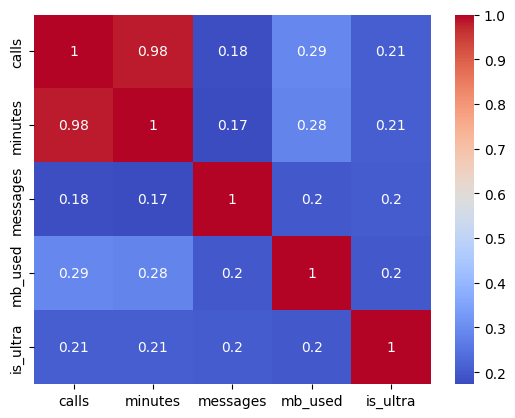

In [7]:
# calculate correlation matrix
correlation_matrix = users.corr()

# visualize the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.show()

#### The provided heatmap visualizes the correlation matrix among the variables: calls, minutes, messages, mb_used, and is_ultra. The color intensity represents the strength of the correlation, ranging from red (strong positive correlation) to blue (strong negative correlation).<br>

#### Calls and minutes exhibit a very strong positive correlation, as indicated by the intense red color. This suggests that users who make more calls tend to also have longer call durations.

#### Messages and minutes show a moderate positive correlation, implying that users who send more messages also tend to have longer call durations.<br>

#### There's a moderate positive correlation between mb_used and minutes, suggesting that users with higher data usage might also have longer calls.<br>

#### The relationship between calls, minutes, and messages with mb_used and is_ultra is relatively weak, as indicated by the lighter colors. This implies that these variables don't significantly influence data usage or ultra plan subscription.<br>

#### Since there are 2 features highly correlated, I will drop one of them on the below step.



In [8]:
clean_users = users.drop(['minutes'], axis=1)
clean_users.head()

,calls,messages,mb_used,is_ultra
0,40.0,83.0,19915.42,0
1,85.0,56.0,22696.96,0
2,77.0,86.0,21060.45,0
3,106.0,81.0,8437.39,1
4,66.0,1.0,14502.75,0


***

### 4. Split the Source Data into a Training Set, a Validation Set, and a Test Set.<br>

### 60% training dataset.<br>
### 20% validating dataset.<br>
### 20% test dataset.

In [9]:
train, valid = train_test_split(clean_users, test_size = 0.4, random_state = 42)
valid_set, test_set = train_test_split(valid, test_size = 0.5, random_state = 42)

In [10]:
train.shape

(1928, 4)

#### 60% for the training dataset is 1928.

In [11]:
valid.shape

(1286, 4)

In [12]:
display(valid_set.shape)
display(test_set.shape)

(643, 4)

(643, 4)

#### 20% for the validating dataset is 643.<br>

#### 20% for the test dataset is 643.

In [13]:
# divides a training dataset into features and a target variable.
features_train = train.drop('is_ultra', axis = 1)
target_train = train['is_ultra']
print(features_train.shape)
print(target_train.shape)

(1928, 3)
(1928,)


In [14]:
# divides a validation dataset into two parts: features and the target variable.
features_valid = valid_set.drop('is_ultra', axis = 1)
target_valid = valid_set['is_ultra']
print(features_valid.shape)
print(target_valid.shape)

(643, 3)
(643,)


In [15]:
# divides a test dataset into two parts: features and the target variable.
features_test = test_set.drop('is_ultra', axis = 1)
target_test = test_set['is_ultra']
print(features_test.shape)
print(target_test.shape)

(643, 3)
(643,)


***

### Decision Tree<br>

#### Model Selection.

In [16]:
# creating the model.
dtc_model = DecisionTreeClassifier(random_state = 42)

#### Model Training.

In [17]:
# training on the training model.
dtc_model = dtc_model.fit(features_train,target_train)

#### Model Evaluation.

In [18]:
#fitting predictions on the valid
valid_pred = dtc_model.predict(features_valid)

In [19]:
# getting the accuracy score
score = dtc_model.score(features_valid, target_valid)
score  

0.7573872472783826

#### <span style="color:blue"> Accuracy 75%

In [ ]:
# plotting the decition tree.
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10), dpi = 300)

tree.plot_tree(dtc_model);

In [27]:
# getting the maximum depth for the tree
dtc_model.tree_.max_depth

32

In [28]:
# interating through a range to see the best accuracy.
final_depth = 0
final_score = 0
for depth in range(1, 10):
    dtc_model_b = DecisionTreeClassifier(random_state = 42, max_depth = depth)
    dtc_model_b.fit(features_train, target_train)
    valid_pred = dtc_model_b.predict(features_valid)
    accuracy = dtc_model_b.score(features_valid, target_valid)
    print("Final depth=", depth, "with accuracy:", accuracy)

Final depth= 1 with accuracy: 0.7558320373250389
Final depth= 2 with accuracy: 0.7916018662519441
Final depth= 3 with accuracy: 0.7962674961119751
Final depth= 4 with accuracy: 0.7822706065318819
Final depth= 5 with accuracy: 0.7916018662519441
Final depth= 6 with accuracy: 0.7838258164852255
Final depth= 7 with accuracy: 0.7884914463452566
Final depth= 8 with accuracy: 0.8133748055987559
Final depth= 9 with accuracy: 0.7978227060653188


#### <span style="color:blue"> Best accuracy for Decition Tree with depth 8 = 81%

#### The Matthews correlation coefficient 

In [29]:
# calculating the matthews correlation coeficient
def calculate_mcc(actual, predicted):
  mcc = matthews_corrcoef(actual, predicted)
  return mcc
mcc_value = calculate_mcc(target_valid, valid_pred)
print("MCC score:", mcc_value)

MCC score: 0.49191333700693857


#### A MCC value of 0.4919 indicates a moderate positive correlation between the predicted and actual values.



#### I will tune the model with the best hyperparameter found.

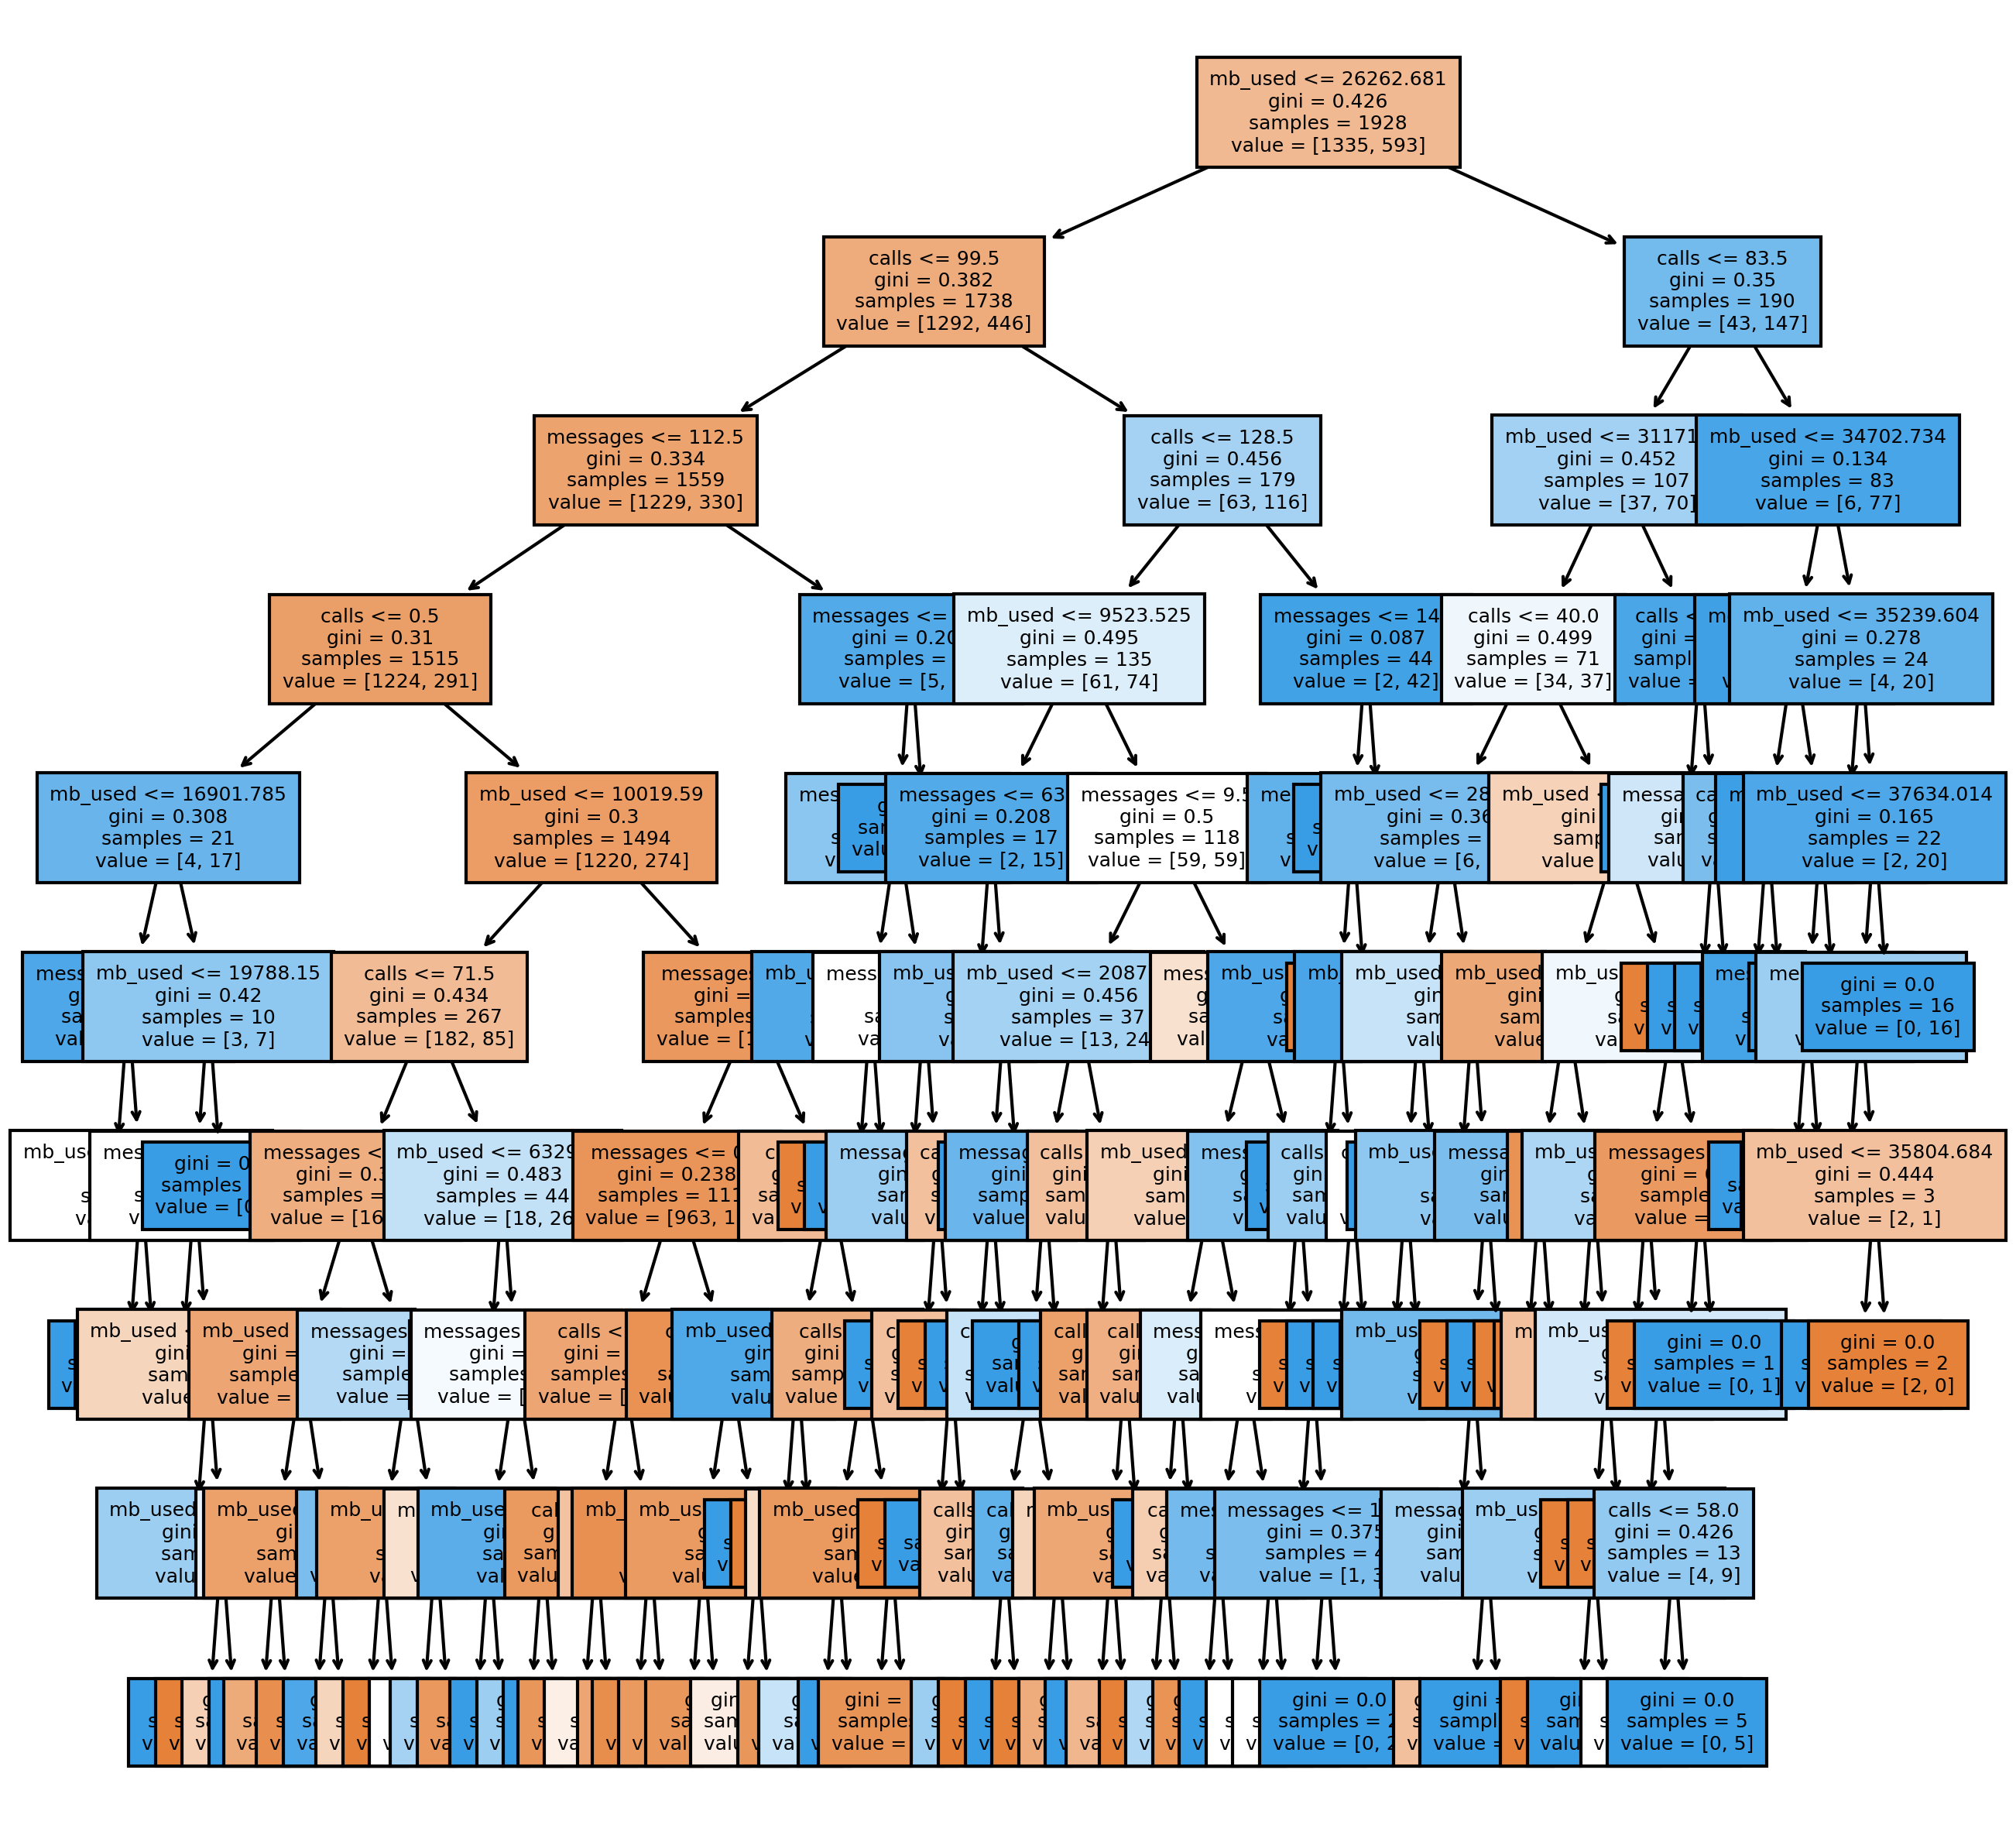

In [30]:
# plotting the tuned decition tree.
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10), dpi = 300)
tree.plot_tree(dtc_model_b,feature_names = features_train.columns,filled = True, fontsize = 6);

#### Confusion Matrix.

#### When having a decision tree model and want to evaluate its performance, the confusion matrix helps understand the number of correct and incorrect predictions made by the model.

In [31]:
# defining the confusion matrix.
cm = confusion_matrix(target_test, valid_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[356  92]
 [162  33]]


#### Analysis<br>
True Negatives (365): The model is good at correctly identifying negative cases.<br>

False Positives (83): There is a moderate number of negative cases being incorrectly classified as positive.<br>

False Negatives (159): The model is missing a significant number of positive cases, which could be problematic depending on the application.<br>

True Positives (36): The model is able to correctly identify some positive cases, but not very many.

#### Further tuning the model with other hyperparameters having in mind the confusion matrix results with class_weight parameter.

In [32]:
# creating the model.
dtc_model_tuned = DecisionTreeClassifier(random_state = 42, class_weight={0: 1, 1: 3.1}, max_depth = 6)
# training on the training model.
dtc_model_tuned = dtc_model_tuned.fit(features_train, target_train)

In [33]:
# model evaluation with the tuned model.
dtc_model_pred = dtc_model_tuned.predict(features_valid)
accuracy_tuned = dtc_model_tuned.score(features_valid, target_valid)
print("Accuracy for dtc_model_tuned:", accuracy_tuned)

Accuracy for dtc_model_tuned: 0.7791601866251944


#### <span style="color:blue"> Accuracy: 77%

#### Variation of tuning for this model:

In [34]:
# creating a param and then fitting it into the model
param_dist = {
    "max_depth": [3, None],
    "max_features": randint(1, 9),
    "min_samples_leaf": randint(1, 9),
    "criterion": ["gini", "entropy"]
}
 
tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)
tree_cv.fit(features_train, target_train)
 
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 7}
Best score is 0.7878675728416662


In [35]:
# testing for final evaluation and trained model. 
dtc_predictions_test = dtc_model_b.predict(features_test)
dtc_accuracy_test = accuracy_score(target_test, dtc_predictions_test)
print("Decision Tree testing score:", dtc_accuracy_test)   

Decision Tree testing score: 0.7962674961119751


#### <span style="color:blue"> Accuracy: 79%

####  Gradient Boosting Classifier.

In [36]:
# Initialize the Gradient Boosting model
gbc_model = GradientBoostingClassifier(random_state=42)

In [37]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}


In [38]:
# Set up GridSearchCV
grid_search = GridSearchCV(estimator = gbc_model, param_grid = param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 2)

# Fit the model on the training data
grid_search.fit(features_train, target_train)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.05],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [39]:
# Best parameters and model
best_params = grid_search.best_params_
best_gbc_model = grid_search.best_estimator_
print("Best Parameters found by Grid Search:", best_params)

# Evaluate the model on the validation set
valid_pred = best_gbc_model.predict(features_valid)
accuracy = best_gbc_model.score(features_valid, target_valid)
print("Validation Accuracy of Tuned Gradient Boosting Model:", accuracy)

Best Parameters found by Grid Search: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Validation Accuracy of Tuned Gradient Boosting Model: 0.8087091757387247


#### <span style="color:blue"> Accuracy: 80%

#### Evaluate the performance of the best-tuned Gradient Boosting model on the test set:

In [40]:
# Evaluate on test data
dtm_gbc_test_pred = best_gbc_model.predict(features_test)
dtm_gbc_test_score = accuracy_score(target_test, dtm_gbc_test_pred)
dtm_gbc_test_mcc = matthews_corrcoef(target_test, dtm_gbc_test_pred)

print("Final Gradient Boosting Classifier test accuracy:", dtm_gbc_test_score)
print("Final Gradient Boosting Classifier test MCC:", dtm_gbc_test_mcc)

Final Gradient Boosting Classifier test accuracy: 0.8118195956454122
Final Gradient Boosting Classifier test MCC: 0.5291200741925689


#### <span style="color:blue"> Test accuracy: 81%

#### Cross-Validation:

In [41]:
model = DecisionTreeClassifier()
# Perform cross-validation
scores = cross_val_score(model, features_train, target_train, cv = 5, scoring = 'accuracy')

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())
print("Standard deviation of cross-validation scores:", scores.std()) 

Cross-validation scores: [0.7357513  0.68134715 0.69948187 0.73246753 0.67792208]
Mean cross-validation score: 0.7053939842540878
Standard deviation of cross-validation scores: 0.024586387951227265


### Analysis:<br>

#### The model achieved an accuracy of 81% on the validation set, which means it correctly classified 81% of the instances. While accuracy is a useful metric, it does not always provide a complete picture, especially in the case of imbalanced classes.<br>

#### The MCC score of 0.49 indicates a moderate correlation between the predicted and actual classes. MCC is considered a more balanced metric than accuracy, particularly when dealing with imbalanced datasets, as it takes into account true positives, false positives, true negatives, and false negatives.<br>

#### The confusion matrix shows that the model correctly identified 356 true negatives and 33 true positives. However, it also misclassified 92 instances as false positives and 162 instances as false negatives.<br>

#### After I tuned the model to reduce the false positives and false negatives based on the confusion matrix results, the model's accuracy has decreased slightly to 77%, down from the previous 81%. This decrease in accuracy is expected because the model is now more focused on correctly identifying the positive class, which may lead to more false positives or a trade-off with correctly identifying negative cases.<br>

#### By setting the class weight to {0: 1, 1: 3.1}, you have effectively told the model to give higher importance to correctly classifying the positive class (class 1). This adjustment is especially useful in situations where false negatives are more costly or dangerous than false positives (e.g., in medical diagnosis or fraud detection).<br>

#### This tuning likely reduced the number of false negatives, which was a key issue in the original model.<br>

#### This analysis suggests that the tuning likely achieved its goal of reducing false negatives, making the model more suitable for situations where identifying the positive class correctly is of high importance, even if overall accuracy decreases slightly.

***

### Random Forest<br>

#### Model Selection.

In [42]:
# creating the model
rfc = RandomForestClassifier(random_state = 42)

#### Model Training.

In [43]:
# training the model
rfc = rfc.fit(features_train, target_train)

#### Model Evaluation.

In [44]:
#fitting predictions on the valid
rfc_valid_pred = rfc.predict(features_valid)

In [45]:
score = rfc.score(features_valid, target_valid)
score  

0.8102643856920684

#### <span style="color:blue"> Accuracy: 81%

#### I will tune the model with different hyperparameters.

In [46]:
# iterating through range of trees to see best accuracy.
final_est = 0
final_score = 0
for n in range(1, 100):
    rfc_model = RandomForestClassifier(random_state = 42, n_estimators = n)
    rfc_model.fit(features_train,target_train)
    rtc_pred = rfc_model.predict(features_valid) 
    rtc_score = rfc_model.score(features_valid, target_valid)
    if score > final_score:
        final_score = score
        best_est = n
    print(n, final_score)

1 0.8102643856920684
2 0.8102643856920684
3 0.8102643856920684
4 0.8102643856920684
5 0.8102643856920684
6 0.8102643856920684
7 0.8102643856920684
8 0.8102643856920684
9 0.8102643856920684
10 0.8102643856920684
11 0.8102643856920684
12 0.8102643856920684
13 0.8102643856920684
14 0.8102643856920684
15 0.8102643856920684
16 0.8102643856920684
17 0.8102643856920684
18 0.8102643856920684
19 0.8102643856920684
20 0.8102643856920684
21 0.8102643856920684
22 0.8102643856920684
23 0.8102643856920684
24 0.8102643856920684
25 0.8102643856920684
26 0.8102643856920684
27 0.8102643856920684
28 0.8102643856920684
29 0.8102643856920684
30 0.8102643856920684
31 0.8102643856920684
32 0.8102643856920684
33 0.8102643856920684
34 0.8102643856920684
35 0.8102643856920684
36 0.8102643856920684
37 0.8102643856920684
38 0.8102643856920684
39 0.8102643856920684
40 0.8102643856920684
41 0.8102643856920684
42 0.8102643856920684
43 0.8102643856920684
44 0.8102643856920684
45 0.8102643856920684
46 0.81026438569206

#### <span style="color:blue"> Best accuracy for Random Forest with number of estimators 1 = 81%

#### Tuning the model with hyperparameters.

In [47]:
# creating a grid for further tuning the model
param_grid = { 
	'n_estimators': list(range(25, 150)), 
	'max_features': ['sqrt', 'log2', None], 
	'max_depth': [3, 6, 9], 
	'max_leaf_nodes': [3, 6, 9],
	'class_weight': [{0: 1, 1: 3.1}]
}

In [ ]:
# fitting the grid into the model
grid_search = GridSearchCV(RandomForestClassifier(), 
						param_grid = param_grid) 
grid_search.fit(features_train, target_train) 
print(grid_search.best_estimator_) 


In [ ]:
# fitting predictions on the test set
target_grid_search = grid_search.predict(features_test) 

In [ ]:
# getting accuracy score for the model
score_grid_search = grid_search.score(features_valid, target_valid)
score_grid_search  

#### <span style="color:blue"> Accuracy: 75%

#### Update the parameters of the model by those which are obtained by using GridSearchCV.

In [ ]:
# getting a grid for fine tuning the model
model_grid = RandomForestClassifier(max_depth = 3, 
									max_features = None, 
									max_leaf_nodes = 6, 
									n_estimators = 36,
         							class_weight={0: 1, 1: 3.1}) 
model_grid.fit(features_train, target_train)


In [ ]:
# fitting predictions on the test set
target_pred_grid = model_grid.predict(features_test) 

In [ ]:
# getting the accuracy score for the model
score_grid_tuned = model_grid.score(features_valid, target_valid)
score_grid_tuned  

#### <span style="color:blue"> Accuracy: 75%

#### Use RandomizedSearchCV to obtain the best parameters for the model.

In [ ]:
# creating a grid for further tuning the model
param_grid_2 = {
    'n_estimators': list(range(25, 150)),
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
# creating the model with randomizedsearchCV
random_search = RandomizedSearchCV(RandomForestClassifier(), 
								param_grid_2) 
random_search.fit(features_train, target_train) 
print(random_search.best_estimator_) 


#### Update the parameters of the model by those which are obtained by using RandomizedSearchCV.

In [ ]:
# fitting the tuned model into the model
model_random = RandomForestClassifier(max_depth = 20, 
									max_features = 'log2',
									min_samples_leaf = 4,
									min_samples_split = 10, 
									n_estimators = 140,) 
model_random.fit(features_train, target_train)


In [ ]:
# fitting predictions on the test set
target_pred_rand = model_random.predict(features_test) 

In [ ]:
# getting the accuracy score
score_pred_rand = model_random.score(features_valid, target_valid)
score_pred_rand  

#### <span style="color:blue"> Accuracy: 82%

In [ ]:
# testing for final evaluation and trained model. 
rfc_predictions_test = rfc_model.predict(features_test)
rfc_accuracy_test = accuracy_score(target_test, rfc_predictions_test)
print("Random Forest testing score:", rfc_accuracy_test) 

#### <span style="color:blue"> Test Accuracy: 81%

#### The Matthews correlation coefficient 

In [ ]:
# calculating the Mathews Correlation coeficient
mcc = matthews_corrcoef(target_valid, target_pred_rand)

print("MCC score:", mcc)

#### A score close to 0 (like 0.007) indicates that the model has very low predictive power. This suggests that the model is struggling to learn from the data and is only slightly better than flipping a coin. In practical terms, such a low MCC score would likely lead to poor decision-making if the model's predictions were used in a real-world application.

#### Let's try to improve the model...

####  Gradient Boosting Classifier.

In [ ]:
# Basic Gradient Boosting Classifier
rfc_gbc = GradientBoostingClassifier(random_state = 42)
rfc_gbc.fit(features_train, target_train)

# Predictions and scoring
rfc_gbc_valid_pred = rfc_gbc.predict(features_valid)
rfc_gbc_score = accuracy_score(target_valid, rfc_gbc_valid_pred)
rfc_gbc_mcc = matthews_corrcoef(target_valid, rfc_gbc_valid_pred)

print("Gradient Boosting Classifier accuracy:", rfc_gbc_score)
print("Gradient Boosting Classifier MCC:", rfc_gbc_mcc)

#### The accuracy score indicates that the model correctly classified approximately 80.87% of the validation data.<br>

#### An MCC of 0.5216 indicates a moderate positive correlation between the predicted and actual classes. It suggests that the model is making meaningful predictions, capturing a significant amount of the signal in the data.<br>

#### The Gradient Boosting Classifier is performing well, with an accuracy of around 81% and an MCC indicating a moderate positive correlation. These metrics together suggest that the model is effective.

#### Tuning the Gradient Boosting Classifier.

In [ ]:
# Hyperparameter tuning for Gradient Boosting Classifier
rfc_param_grid_gbc = {
    'n_estimators': list(range(25, 150)),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [ ]:
# Grid Search
rfc_grid_search_gbc = GridSearchCV(GradientBoostingClassifier(random_state = 42), param_grid = rfc_param_grid_gbc, cv = 3)
rfc_grid_search_gbc.fit(features_train, target_train)

#### This tuned model takes a long time to run.

In [ ]:
# Best estimator
rf_best_gbc = rfc_grid_search_gbc.best_estimator_
print("Best Gradient Boosting Classifier:", rf_best_gbc)

In [ ]:
# Evaluating on the validation set
rfc_gbc_best_valid_pred = rf_best_gbc.predict(features_valid)
rfc_gbc_best_score = accuracy_score(target_valid, rfc_gbc_best_valid_pred)
rfc_gbc_best_mcc = matthews_corrcoef(target_valid, rfc_gbc_best_valid_pred)

print("Tuned Gradient Boosting Classifier accuracy:", rfc_gbc_best_score)
print("Tuned Gradient Boosting Classifier MCC:", rfc_gbc_best_mcc)

#### <span style="color:blue"> Accuracy: 81%

#### Evaluate the performance of the best-tuned Gradient Boosting model on the test set:

In [ ]:
# Evaluate on test data
rfc_gbc_test_pred = rf_best_gbc.predict(features_test)
rfc_gbc_test_score = accuracy_score(target_test, rfc_gbc_test_pred)
rfc_gbc_test_mcc = matthews_corrcoef(target_test, rfc_gbc_test_pred)

print("Final Gradient Boosting Classifier test accuracy:", rfc_gbc_test_score)
print("Final Gradient Boosting Classifier test MCC:", rfc_gbc_test_mcc)

#### <span style="color:blue"> Test Accuracy: 81%

#### Cross-Validation:

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 102, random_state = 42)

# Perform cross-validation
rf_scores = cross_val_score(rf_model, features_train, target_train, cv = 5, scoring = 'accuracy')

print("Cross-validation scores:", rf_scores)
print("Mean cross-validation score:", rf_scores.mean())
print("Standard deviation of cross-validation scores:", rf_scores.std())

### Analysis:<br>

#### The accuracy of the Gradient Boosting Classifier is consistently above 81% on both the validation and test sets. This indicates that the model is performing well and generalizes well to unseen data, as there is a small increase in accuracy from the validation set to the test set.<br>

#### The MCC values are 0.53 for the validation set and 0.54 for the test set.<br>

#### An MCC value between 0.5 and 0.6 typically indicates a moderate positive correlation between the predicted and actual classes, suggesting that the model has a good balance between sensitivity and specificity.<br>

#### The close alignment between the validation and test results suggests that the model is not overfitting and has learned a robust pattern from the data.<br>

#### The Tuned Gradient Boosting Classifier shows solid performance on both the validation and test sets, with accuracy slightly above 81% and MCC around 0.53-0.54. The consistency between these metrics indicates that the model is reliable and well-balanced, making it a strong candidate for deployment in a real-world scenario where prediction accuracy and balanced performance across all classes are critical.

***

### Logistics Regression<br>

#### Model Selection.

In [ ]:
# creating the model
lr_model = LogisticRegression(random_state = 42, solver = 'liblinear')

#### Model Training.

In [ ]:
# fitting the model into the training set
lr_model.fit(features_train,target_train)

#### Model Evaluation.

In [ ]:
#fitting predictions on the valid
lr_valid_pred = lr_model.predict(features_valid)

In [ ]:
# getting the accuracy for the model
lr_score = lr_model.score(features_valid, target_valid)
lr_score  

#### <span style="color:blue"> Accuracy for Logistic Regression Model: 71%

#### I will tune the model with different hyperparameters.

In [ ]:
# modifying hyperparameters for the model
C = [0.001, 0.01, 0.1, 1, 10]
penalty = ['l1', 'l2']
solver = ['liblinear']
max_iter = [500, 1000, 5000]
hyperparameters = dict(C = C, penalty = penalty, solver = solver, max_iter = max_iter)

In [ ]:
# tuning the model using gridsearchCV
logistic = linear_model.LogisticRegression()
gridsearch = GridSearchCV(logistic, hyperparameters)

In [ ]:
# fitting the tuned model into the training set
lr_best_model_grid = gridsearch.fit(features_train, target_train)
print(lr_best_model_grid.best_estimator_)

In [ ]:
# using the best hyperparameters for the model
lr_model_grid = LogisticRegression(max_iter = 5000,
								   C = 10,
                                   penalty = 'l1',
								   solver = 'liblinear') 
lr_model_grid.fit(features_train, target_train)

In [ ]:
#fitting predictions on the valid
lr_pred_grid = lr_model_grid.predict(features_valid)

In [ ]:
# getting the accuracy score
lr_score_grid = lr_model_grid.score(features_valid, target_valid)
print("Updated Logistic Regression model score:", lr_score_grid)

#### <span style="color:blue"> Accuracy: 72%

In [ ]:
# further tuning the model using randomizedsearchCV
randomizedsearch = RandomizedSearchCV(logistic, hyperparameters)
best_model_random = randomizedsearch.fit(features_train, target_train)
print(best_model_random.best_estimator_)

In [ ]:
# fitting the new hyperparameters into the model
lr_random_grid = LogisticRegression(max_iter =1000,
								   C = 10,
                                   penalty = 'l1',
								   solver = 'liblinear') 
lr_random_grid.fit(features_train, target_train)

In [ ]:
#fitting predictions on the valid
lr_pred_grid = lr_random_grid.predict(features_valid)

In [ ]:
# getting the accuracy score
lr_random_score = lr_random_grid.score(features_valid, target_valid)
print("Random Search Logistic Regression model score:", lr_random_score)

#### <span style="color:blue"> Accuracy: 73%

In [ ]:
# testing for final evaluation and trained model. 
lr_predictions_test = lr_model_grid.predict(features_test)
lr_accuracy_test = accuracy_score(target_test, lr_predictions_test)
print("Logistic Regression testing score:", lr_accuracy_test) 

#### <span style="color:blue"> Test Accuracy: 76%

#### The initial Logistic Regression model achieved an accuracy score of 71% on the validation set.<br>
#### This indicates that the model correctly classified 71% of the validation data. While this is a decent starting point, it suggests there's room for improvement.<br>

#### After tuning the model, the accuracy improved slightly to 73% on the validation set.<br>
#### This improvement (2 percentage points) suggests that the tuning process was somewhat effective. The small gain implies that the hyperparameters were closer to optimal after tuning, but there might still be limitations in the model's ability to capture the patterns in the data.<br>

#### When the tuned model was evaluated on the test set, it achieved an accuracy of 76%.<br>
#### This score is higher than both the initial and tuned validation scores, indicating that the model generalizes well to unseen data. It also suggests that the tuning process not only improved performance on the validation set but also helped the model perform better on new data.<br>

#### The gradual improvement in accuracy from 71% to 76% across the different stages indicates that the model tuning process was effective, though the gains were modest. The final test set accuracy of 76% suggests that the model is reasonably good at making predictions on new data, but there might still be room for further refinement, especially if higher accuracy is desired.

#### Let's try to improve the performance...

####  Gradient Boosting Classifier.

In [ ]:
# Basic Gradient Boosting Classifier
lr_gbc_model = GradientBoostingClassifier(random_state = 42)
lr_gbc_model.fit(features_train, target_train)

# Predictions and scoring on the validation set
lr_gbc_valid_pred = lr_gbc_model.predict(features_valid)
lr_gbc_valid_score = accuracy_score(target_valid, lr_gbc_valid_pred)
lr_gbc_valid_mcc = matthews_corrcoef(target_valid, lr_gbc_valid_pred)

print("Gradient Boosting Classifier validation score:", lr_gbc_valid_score)
print("Gradient Boosting Classifier validation MCC:", lr_gbc_valid_mcc)

#### <span style="color:blue"> Accuracy: 80%

#### Tuning the Gradient Boosting Classifier.

In [ ]:
# Define the parameter grid
lr_param_grid_gbc = {
    'n_estimators': [50, 100, 150],       
    'learning_rate': [0.01, 0.05, 0.1],     
    'max_depth': [3, 5, 7],                
    'min_samples_split': [2, 5, 10],         
    'min_samples_leaf': [1, 2, 4]            
}
# Grid Search
lr_grid_search_gbc = GridSearchCV(GradientBoostingClassifier(random_state = 42), param_grid = lr_param_grid_gbc, cv = 3)
lr_grid_search_gbc.fit(features_train, target_train)

# Best estimator
lr_best_gbc = lr_grid_search_gbc.best_estimator_
print("Best Gradient Boosting Classifier:", lr_best_gbc)

# Evaluating on the validation set
lr_gbc_best_valid_pred = lr_best_gbc.predict(features_valid)
lr_gbc_best_valid_score = accuracy_score(target_valid, lr_gbc_best_valid_pred)
lr_gbc_best_valid_mcc = matthews_corrcoef(target_valid, lr_gbc_best_valid_pred)


print("Tuned Gradient Boosting Classifier validation score:", lr_gbc_best_valid_score)
print("Tuned Gradient Boosting Classifier validation MCC:", lr_gbc_best_valid_mcc)

#### <span style="color:blue"> Accuracy: 80%

#### Evaluate the performance of the best-tuned Gradient Boosting model on the test set:

In [ ]:
# Evaluate on the test data
lr_gbc_test_pred = lr_best_gbc.predict(features_test)
lr_gbc_test_score = accuracy_score(target_test, lr_gbc_test_pred)
lr_gbc_test_mcc = matthews_corrcoef(target_test, lr_gbc_test_pred)

print("Final Gradient Boosting Classifier test score:", lr_gbc_test_score)
print("Final Gradient Boosting Classifier test MCC:", lr_gbc_test_mcc)

#### <span style="color:blue"> Test Accuracy: 82%

#### Cross-Validation:

In [ ]:
lr_model = LogisticRegression(random_state = 42, solver = 'liblinear')

# Perform cross-validation with 5 folds
lr_scores = cross_val_score(lr_model, features_train, target_train, cv = 5, scoring = 'accuracy')

print("Cross-validation scores:", lr_scores)
print("Mean cross-validation score:", lr_scores.mean())
print("Standard deviation of cross-validation scores:", lr_scores.std())

### Analysis:<br>

#### The model achieves an accuracy of 80.40% on the validation set, indicating that it has been tuned effectively to generalize well on unseen data during the tuning process.<br>
#### This score shows that the model is able to capture the underlying patterns in the data sufficiently well without overfitting, as the validation score reflects how well the model might perform on new, unseen data.<br>

#### After tuning, the model's accuracy slightly decreases to 80.4%, which is very close to the initial model's performance. The MCC also drops slightly to 0.5085. This minor decrease suggests that the tuning did not drastically improve or degrade the model's performance, implying that the original hyperparameters were already fairly optimal.<br>

#### The MCC on the test set is 0.5608, which is higher than the MCC on the validation set, suggesting that the model is even better balanced when predicting on new data.<br>

#### The accuracy on the test set is 82.43%, which is slightly higher than the validation set accuracy. This suggests that the model generalizes even better when applied to the test data.<br>
#### The increase in performance from the validation set to the test set might indicate that the test set is slightly easier or more aligned with the training data, or it could suggest that the model is well-calibrated and capable of handling variations in the data effectively.<br>

#### The small increase from 80.40% (validation) to 82.43% (test) suggests that the model is consistent and reliable. This consistency is crucial for real-world applications where the model needs to perform well on new data.<br>

#### The model has demonstrated good generalization capabilities, as evidenced by the strong performance on both the validation and test sets. This indicates that the model is not overfitted to the training data and can adapt well to new data points.<br>

#### The chosen hyperparameters contribute to the model's ability to capture the patterns in the data without overfitting, making it a robust solution for the given classification task.


***

### Kneighbors Classifier<br>

#### Model Selection.

In [ ]:
# creating the model
knn = KNeighborsClassifier(n_neighbors = 3)

#### Model Training.

In [ ]:
# fitting the model into the training set
knn.fit(features_train, target_train)

#### Model Evaluation.

In [ ]:
# creating predictions for the model
knn_predictions = knn.predict(features_valid)

In [ ]:
# getting accuracy for the model
knn_score = knn.score(features_valid, target_valid)
knn_score

#### <span style="color:blue"> Accuracy: 73%

#### I will tune the model with different hyperparameters.

In [ ]:
# Define a range of neighbors to test
param_grid_knn = {
    'n_neighbors': np.arange(2, 30, 1),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

In [ ]:
# Define cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# Initialize KNN and GridSearchCV
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid = param_grid_knn, cv = kf, scoring = 'accuracy', verbose = 1)
grid_search_knn.fit(features_train, target_train)

In [ ]:
# Best parameters and model
best_knn = grid_search_knn.best_estimator_
print("Best KNN parameters:", grid_search_knn.best_params_)

In [ ]:
# Evaluate the tuned model on the validation set
knn_valid_pred = best_knn.predict(features_valid)
knn_valid_score = accuracy_score(target_valid, knn_valid_pred)
knn_valid_mcc = matthews_corrcoef(target_valid, knn_valid_pred)

print("Tuned KNN validation accuracy:", knn_valid_score)
print("Tuned KNN validation MCC:", knn_valid_mcc)

#### <span style="color:blue"> Accuracy: 75%

#### The initial K-Neighbors Classifier model achieved an accuracy score of 73% on the validation set.<br>
#### This indicates that the model correctly classified 73% of the validation data. It serves as a baseline to compare against after tuning.<br>

#### After tuning the model with the best hyperparameters, the accuracy improved slightly to 75% on the validation set.<br>
#### The small increase of 2 percentage points suggests that the tuning process was beneficial, though the improvement is modest.<br>

#### An MCC of 0.35 suggests a moderate level of predictive performance, indicating that while the model is better than random guessing, there is room for improvement, especially in capturing the relationships in the data.<br>

#### The model is somewhat effective but might benefit from further refinement or from exploring different models to capture the data's underlying patterns better. The small increase in accuracy combined with a moderate MCC score suggests that while the model is heading in the right direction, it may not be fully capturing the complexity of the problem.


#### I will try to improve its performance on the next step...

####  Gradient Boosting Classifier.

In [ ]:
# Basic Gradient Boosting Classifier
knn_gbc_model = GradientBoostingClassifier(random_state=42)
knn_gbc_model.fit(features_train, target_train)

In [ ]:
# Predictions and scoring on the validation set
knn_gbc_valid_pred = knn_gbc_model.predict(features_valid)
knn_gbc_valid_score = accuracy_score(target_valid, knn_gbc_valid_pred)
knn_gbc_valid_mcc = matthews_corrcoef(target_valid, knn_gbc_valid_pred)

print("Basic Gradient Boosting Classifier validation accuracy:", knn_gbc_valid_score)
print("Basic Gradient Boosting Classifier validation MCC:", knn_gbc_valid_mcc)

#### <span style="color:blue"> Accuracy: 80%

#### Tuning the Gradient Boosting Classifier.

In [ ]:
# Define the parameter grid for tuning
knn_param_grid_gbc = {
    'n_estimators': [50, 100, 150],       
    'learning_rate': [0.01, 0.05, 0.1],     
    'max_depth': [3, 5, 7],                
    'min_samples_split': [2, 5, 10],         
    'min_samples_leaf': [1, 2, 4]            
}

In [ ]:
# Grid Search
knn_grid_search_gbc = GridSearchCV(GradientBoostingClassifier(random_state = 42), param_grid = knn_param_grid_gbc, cv = 3, scoring = 'accuracy')
knn_grid_search_gbc.fit(features_train, target_train)

In [ ]:
# Best estimator
knn_best_gbc = knn_grid_search_gbc.best_estimator_
print("Best Gradient Boosting Classifier:", knn_best_gbc)

In [ ]:
# Evaluating on the validation set
knn_gbc_best_valid_pred = knn_best_gbc.predict(features_valid)
knn_gbc_best_valid_score = accuracy_score(target_valid, knn_gbc_best_valid_pred)
knn_gbc_best_valid_mcc = matthews_corrcoef(target_valid, knn_gbc_best_valid_pred)

print("Tuned Gradient Boosting Classifier validation accuracy:", knn_gbc_best_valid_score)
print("Tuned Gradient Boosting Classifier validation MCC:", knn_gbc_best_valid_mcc)

#### <span style="color:blue"> Accuracy: 80%

In [ ]:
# Evaluate on the test data
knn_gbc_test_pred = knn_best_gbc.predict(features_test)
knn_gbc_test_score = accuracy_score(target_test, knn_gbc_test_pred)
knn_gbc_test_mcc = matthews_corrcoef(target_test, knn_gbc_test_pred)

print("Final Gradient Boosting Classifier test accuracy:", knn_gbc_test_score)
print("Final Gradient Boosting Classifier test MCC:", knn_gbc_test_mcc)

#### <span style="color:blue"> Test Accuracy: 82%

#### Cross-Validation:

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors = 5)

knn_scores = cross_val_score(knn_model, features_train, target_train, cv = 5, scoring = 'accuracy')

print("Cross-validation scores:", knn_scores)
print("Mean cross-validation score:", knn_scores.mean())
print("Standard deviation of cross-validation scores:", knn_scores.std())

### Analysis:<br>

#### The accuracy on the validation set remained consistent at 80% before and after tuning, indicating that the initial model was already well-calibrated for accuracy. The slight increase to 82% on the test set is a positive sign, suggesting that the model generalizes well to unseen data.<br>

#### The MCC decreased slightly after tuning (from 0.52 to 0.50) on the validation set but improved on the test set (0.56). MCC provides a more balanced evaluation, especially for imbalanced datasets.<br>

#### The final MCC of 0.56 on the test set indicates a moderate to good level of predictive power. This improvement suggests that the model's ability to correctly classify both positive and negative cases has strengthened when applied to new data.<br>

#### This suggests the model is well-calibrated and generalizes effectively to unseen data, making it a solid performer for this classification task. Further tuning or model adjustments could potentially push these metrics even higher.

***

### 9. Sanity Check the Model<br>

#### Decisition Tree.

In [ ]:
# performing a sanity check for the best decition tree model
y_prob = best_gbc_model.predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, y_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
# print the sanity check score
print(f"ROC AUC Score: {roc_auc}")

#### A ROC AUC score of 0.841 suggests that your decision tree model has a good ability to distinguish between the positive and negative classes. This means that the model is performing well and is generally reliable in differentiating between classes.<br>

#### After doing a sanity check, this score suggests that the model is functioning correctly and is not just randomly guessing. The model’s predictions are meaningfully aligned with the actual class labels, and it is making distinctions with a good degree of accuracy.

#### Random Forest.

In [ ]:
# performing a sanity check for the best random forest model
rf_y_prob = rf_best_gbc.predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, rf_y_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
# print the sanity check result
print(f"ROC AUC Score: {roc_auc}")

#### The score of 0.8496, which falls within the range that is typically considered to represent good discrimination. This means that the Random Forest model is effective at distinguishing between the positive and negative classes in your data.<br>

#### Given that this score is well above 0.5, it confirms that the model is performing better than random guessing. The model is successfully capturing patterns in the data that help it to differentiate between classes.

#### Logistics Regression.

In [ ]:
# performing a sanity check for the best logistics regression model
lr_y_prob = lr_best_gbc.predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, lr_y_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
# print the sanity check result
print(f"ROC AUC Score: {roc_auc}")


#### A score of 0.8356 indicates that the Logistic Regression model is able to effectively distinguish between the positive and negative classes in the dataset. This means that the model is correctly ranking the instances with a high degree of accuracy, where a higher score for a given instance correlates with a higher likelihood of it being classified into the positive class.<br>

#### Since the ROC AUC score ranges from 0 to 1, a score of 0.5 would mean the model is no better than random guessing. A score of 0.8356 is well above 0.5, confirming that the model is performing significantly better than random guessing.

#### Kneighbors Classifier.

In [ ]:
# performing a sanity check for the best kneighbors classifier model
knn_y_prob = knn_best_gbc.predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, knn_y_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
# print the sanity check result
print(f"ROC AUC Score: {roc_auc}")

#### A ROC AUC score of 0.8356 indicates that the k-NN classifier is effectively distinguishing between the positive and negative classes in the dataset. This means the model is accurately ranking instances, where a higher score corresponds to a higher likelihood of being classified as the positive class.<br>

#### Since the ROC AUC score ranges from 0 to 1, with 0.5 representing random guessing, a score of 0.8356 shows that the model is performing significantly better than random chance.

***

### Final Conclusion<br>

#### <ins>Decision Tree Model:<ins><br>

#### Performance: This model shows the lowest performance in both accuracy and MCC compared to other models. However, it has a decent ROC AUC score (0.8413) and might be more interpretable but lacks in performance.

#### <ins>Random Forest Model:<ins><br>

#### Best Performance: This model has the highest test accuracy (0.8180), a high MCC (0.5448), and the highest ROC AUC score (0.8497), which indicates a strong ability to differentiate between classes.<br>

#### Cross-Validation: The mean cross-validation score is the highest (0.7931) among all models, and while it has the highest standard deviation, the trade-off seems reasonable given its overall performance.<br>

#### Downside: The random forest model takes the longest time to run

#### <ins>Logistic Regression Model:<ins><br>

#### Accuracy and MCC: The test accuracy is the highest (0.8243) among all models, and it has the highest MCC (0.5608), suggesting good model performance in terms of balanced accuracy.<br>

#### ROC AUC: The ROC AUC score is slightly lower than that of the random forest, but still quite strong (0.8356).<br>

#### Cross-Validation: The cross-validation mean score is 0.7277, which is lower than that of the random forest but more stable.

#### <ins>K-Neighbors Classifier Model:<ins><br>

#### Performance: Similar to logistic regression, this model has the same test accuracy and MCC. However, the ROC AUC score is slightly lower than that of the decision tree and random forest, and its cross-validation score is lower than that of the logistic regression.

#### <ins>Conclusion:<ins><br>

#### Best Overall Model: Random Forest is the best overall performer, with a strong ROC AUC score, high accuracy, and a decent MCC. It is robust and provides the best classification performance, though at the cost of computation time.<br>

#### Alternative (if time is a constraint): If runtime is a concern, Logistic Regression is a strong alternative. It offers a high accuracy and MCC with more stable cross-validation results, making it a good choice when considering both performance and efficiency.

***

Cesar Chaparro, Data Analyst